In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from pulp import *

%matplotlib inline

In [2]:
t = pd.read_csv('../csv/stochastic_matrix.csv', index_col=0).fillna(0)

In [3]:
v = t.T[[
    'R00200', 'R00268', 'R00341', 'R00342', 'R00351',
    'R00405', 'R00658', 'R00703', 'R01015', 'R01049',
    'R01056', 'R01061', 'R01070', 'R01082', 'R01196', 
    'R01197', 'R01325', 'R01512', 'R01518', 'R01528',
    'R01529', 'R01641', 'R01786', 'R01830', 'R01899',
    'R01900', 'R02035', 'R02164', 'R02740', 'R04779'
]].T

for i in v.columns:
    if sum(v[i] == 0) == v.shape[0]:
        v = v.drop(i, axis=1)
        
v['C00007'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00033'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00092'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00014'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00025'] = pd.Series(np.zeros(v.shape[0]), index=v.index)

# v['C00279'] = pd.Series(np.zeros(v.shape[0]), index=v.index)

In [4]:
df = v.T
df['Glucose_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glucose_input']['C00267'] = 1

df['Oxygen_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxygen_input']['C00007'] = 1

df['CO2_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['CO2_output']['C00011'] = -1

df['Lactate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Lactate_output']['C00186'] = -1

# df['Succinate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Succinate_output']['C00042'] = -1

# df['Malate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Malate_output']['C00149'] = -1

# df['Fumarate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Fumarate_output']['C00122'] = -1

df['Acetate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Acetate_output']['C00033'] = -1

# df['Glutamate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Glutamate_output']['C00025'] = -1

df['Glutamate_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glutamate_input']['C00025'] = 1

df['Ammonia_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Ammonia_output']['C00014'] = -1

df['Glu_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glu_Exchange']['C00267'] = -1
df['Glu_Exchange']['C00092'] = 1

df['acetyl_CoA_hydrolase'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['acetyl_CoA_hydrolase']['C00024'] = -1
df['acetyl_CoA_hydrolase']['C00001'] = -1
df['acetyl_CoA_hydrolase']['C00010'] = 1
df['acetyl_CoA_hydrolase']['C00033'] = 1

df['NADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['NADP_Exchange']['C00005'] = -1
df['NADP_Exchange']['C00003'] = -1
df['NADP_Exchange']['C00006'] = 1
df['NADP_Exchange']['C00004'] = 1

df['ADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['ADP_Exchange']['C00002'] = -1
df['ADP_Exchange']['C00008'] = 1

df['AMP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['AMP_Exchange']['C00002'] = -1
df['AMP_Exchange']['C00020'] = -1
df['AMP_Exchange']['C00008'] = 2

df['R00835'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00835']['C00092'] = -1
df['R00835']['C00006'] = -1
df['R00835']['C01236'] = 1
df['R00835']['C00005'] = 1
df['R00835']['C00080'] = 1

df['R08575'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R08575']['C05382'] = -1
df['R08575']['C00118'] = -1
df['R08575']['C00279'] = 1
df['R08575']['C00085'] = 1

df['R02164']['C00004'] = -1
df['R02164']['C00003'] = 1
df['R02164']['C15602'] = 0
df['R02164']['C15603'] = 0

df['R00243'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00243']['C00025'] = -1
df['R00243']['C00003'] = -1
df['R00243']['C00001'] = -1

df['R00243']['C00026'] = 1
df['R00243']['C00014'] = 1
df['R00243']['C00004'] = 1
df['R00243']['C00080'] = 1

# Oxophos
df['Oxophos'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxophos']['C00004'] = -2
df['Oxophos']['C00007'] = -1
df['Oxophos']['C00008'] = -5
df['Oxophos']['C00002'] = 5
df['Oxophos']['C00003'] = 2
df['Oxophos']['C00011'] = 1

In [5]:
BIOMASS = pd.read_csv('../csv/amino_acid.csv',index_col=0)
# BIOMASS = BIOMASS[BIOMASS.index != 'NH3']
df_Biomass =  pd.Series(np.zeros(df.shape[0]), index=df.index)

for i in BIOMASS.index:
    df_Biomass[BIOMASS.T[i]['C_num']] = BIOMASS.T[i]['flux']
    
df_Biomass['C00668'] = -0.27519
df_Biomass['C00119'] = (-0.039036) + (-0.036117) + (-0.053446)

In [6]:
df_new = pd.concat([df_Biomass.T, df], axis=1)
df_new = df_new.rename(columns={0: 'BIOMASS'})
df_new = df_new.drop([
    'C00001','C00009','C00080','C00138','C00139','C15602','C15603', 
#     'C00231'
])

In [7]:
rate = pd.DataFrame()
for l in range(0, 1000, 1):
    x = []
    for i in df_new.columns:
        if (
                (i=='Oxophos') or (i=='R01899') or (i=='R00268') or (i=='R10343') or (i=='R02164') or (i=='R00835') or (i=='R02035') or
                (i=='CO2') or (i == 'Lactate') or (i == 'Acetate') or (i == 'Succinate') or (i == 'Malate') or (i=='ATP_Exchange') or (i=='AMP_Exchange') or
                (i=='Glutamate_output') or (i=='CO2_output') or  (i=='Lactate_output') or (i=='Glutamate_output') or (i=='Ammonia_output')
        ):
            x.append(LpVariable(i, lowBound=0,upBound=10000, cat='Continuous'))

        elif (i=='Glucose_input'):
            x.append(LpVariable(i, lowBound=0, upBound=l, cat='Continuous'))
            
        elif (i=='BIOMASS'):
            x.append(LpVariable(i, lowBound=0, upBound=100, cat='Continuous'))

        elif (i=='Glutamate_input'):
            x.append(LpVariable(i, lowBound=0, upBound=100, cat='Continuous'))
            
        elif (
            (i=='Succinate_output') or (i=='Malate_output') or (i=='Fumarate_output') or (i=='Acetate_output')
        ):
            x.append(LpVariable(i, lowBound=0, upBound=50, cat='Continuous'))

        elif (i=='R00200') or (i=='R01196') or (i=='R01197') or (i=='R00405'):
            x.append(LpVariable(i, lowBound=-10000, upBound=0, cat='Continuous'))

        else:
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))

    m = LpProblem(sense=LpMaximize)
    m += x[0]

    for i in np.dot(df_new, x):
        m += i == 0

    status = m.solve()
    print(LpStatus[status])

    y = []
    for i in x:
        y.append(i.value())

    rate = pd.concat([rate,pd.DataFrame(y, index=x).T])

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


In [8]:
rate.columns = [str(i) for i in list(rate.columns)]
rate.index = range(0, 1000)

In [9]:
(rate.columns)

Index(['BIOMASS', 'R00200', 'R00268', 'R00341', 'R00342', 'R00351', 'R00405',
       'R00658', 'R00703', 'R01015', 'R01049', 'R01056', 'R01061', 'R01070',
       'R01082', 'R01196', 'R01197', 'R01325', 'R01512', 'R01518', 'R01528',
       'R01529', 'R01641', 'R01786', 'R01830', 'R01899', 'R01900', 'R02035',
       'R02164', 'R02740', 'R04779', 'Glucose_input', 'Oxygen_input',
       'CO2_output', 'Lactate_output', 'Acetate_output', 'Glutamate_input',
       'Ammonia_output', 'Glu_Exchange', 'acetyl_CoA_hydrolase',
       'NADP_Exchange', 'ADP_Exchange', 'AMP_Exchange', 'R00835', 'R08575',
       'R00243', 'Oxophos'],
      dtype='object')

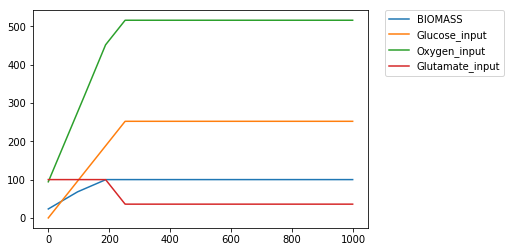

In [10]:
rate[[
    'BIOMASS', 'Glucose_input', 'Oxygen_input', 'Glutamate_input', 
]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)

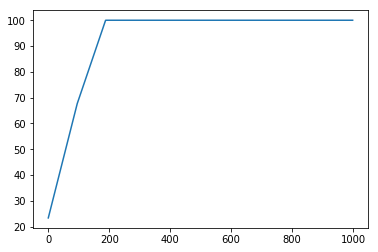

In [11]:
rate['BIOMASS'].plot()

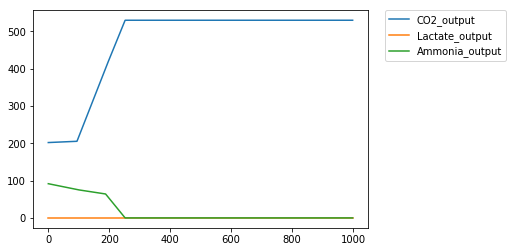

In [12]:
rate[[
    'CO2_output', 'Lactate_output', 
#     'Succinate_output', 
#     'Malate_output', 'Fumarate_output', 'Acetate_output', 
    'Ammonia_output'
]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)

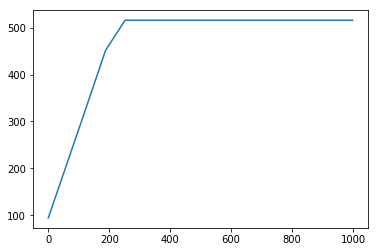

In [13]:
rate['Oxygen_input'].plot()

In [14]:
rate[[
    'Lactate_output', 'Ammonia_output', 'Glucose_input', 'Glutamate_input'
]]

,Lactate_output,Ammonia_output,Glucose_input,Glutamate_input
0,0.0,91.602622,0.0000,100.000
1,0.0,91.434674,1.0000,100.000
2,0.0,91.266727,2.0000,100.000
3,0.0,91.098779,3.0000,100.000
4,0.0,90.930831,4.0000,100.000
5,0.0,90.762884,5.0000,100.000
6,0.0,90.594936,6.0000,100.000
7,0.0,90.426989,7.0000,100.000
8,0.0,90.259041,8.0000,100.000
9,0.0,90.091094,9.0000,100.000


In [15]:
rate[['Glucose_input', 'Oxygen_input',
       'CO2_output', 'Lactate_output', 'Acetate_output', 'Glutamate_input',
       'Ammonia_output', 'Glu_Exchange']]

,Glucose_input,Oxygen_input,CO2_output,Lactate_output,Acetate_output,Glutamate_input,Ammonia_output,Glu_Exchange
0,0.0000,94.315338,201.78874,0.0,0.0,100.000,91.602622,0.0
1,1.0000,96.201644,201.82451,0.0,0.0,100.000,91.434674,0.0
2,2.0000,98.087951,201.86029,0.0,0.0,100.000,91.266727,0.0
3,3.0000,99.974258,201.89606,0.0,0.0,100.000,91.098779,0.0
4,4.0000,101.860560,201.93184,0.0,0.0,100.000,90.930831,0.0
5,5.0000,103.746870,201.96761,0.0,0.0,100.000,90.762884,0.0
6,6.0000,105.633180,202.00339,0.0,0.0,100.000,90.594936,0.0
7,7.0000,107.519480,202.03916,0.0,0.0,100.000,90.426989,0.0
8,8.0000,109.405790,202.07494,0.0,0.0,100.000,90.259041,0.0
9,9.0000,111.292100,202.11071,0.0,0.0,100.000,90.091094,0.0


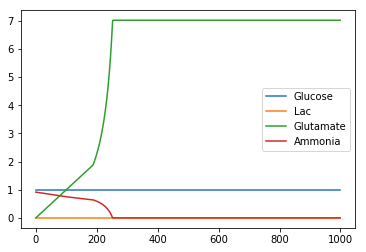

In [16]:
norm_result = pd.concat([
    pd.DataFrame(rate[ 'Glutamate_input']/rate['Glutamate_input']),
    pd.DataFrame(rate[ 'Lactate_output']/rate['Glutamate_input']),
    pd.DataFrame(rate[ 'Glucose_input']/rate['Glutamate_input']), 
    pd.DataFrame(rate[ 'Ammonia_output']/rate['Glutamate_input'])],
    axis=1
)
#     'Glucose_input', 'Lactate_output', 'Glutamate_input', 'Ammonia_output'
norm_result.columns = ['Glucose', 'Lac', 'Glutamate', 'Ammonia']
norm_result.plot()

In [17]:
norm_result.to_csv('../result/grad_glc.csv')